In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px  # to plot the time series plot
from sklearn import metrics  # for the evaluation
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from foursquareAPI import get_poi

In [31]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
print(df)

                         Parkirisce  Prosta mesta  Kapaciteta  Zasedenost  \
0                          Bezigrad            58          64           6   
1                    Center Stozice           142         509         367   
2       Dolenjska cesta (Strelisce)            50          67          17   
3                   Gosarjeva ulica            16         190         174   
4               Gosarjeva ulica II.           121         115          -6   
...                             ...           ...         ...         ...   
292887                  SRC Stozice             0           0           0   
292888                        Tacen             0           0           0   
292889                 Bratislavska             0           0           0   
292890                       BS4/ I            63          80          17   
292891                      BS4/ II             8          83          75   

                      date  
0      2022-02-24 19:13:21  
1      2022-02-24

In [32]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync

In [33]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    points_of_interest = get_poi(name, radius=50) # Add points of interest to dataframe

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = parking["Kapaciteta"]
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    
    parking_sync["Points_of_interest"] = ["" if not points_of_interest else points_of_interest[0] for _ in range(len(parking_sync.index))] # NOTE: points_of_interest[0] - take only the first element to get 1d array

    # # Print entire dataframe
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     print(parking_sync)

    parkings[name] = parking_sync  # Save the synced data frame to dict

    # plt.plot(parking_sync["Zasedenost"])
    # plt.gcf().autofmt_xdate()
    # plt.xlabel("Datum")
    # plt.ylabel("Stevilo zasedenih mest")
    # plt.title(f"Parkirisce: {name}")
    # plt.show()

print(parkings)

{'BS4/ I':                      Zasedenost  Kapaciteta Points_of_interest
date                                                          
2022-03-04 09:31:53         0.0          80         Restaurant
2022-03-04 09:41:53         0.0          80         Restaurant
2022-03-04 09:51:53         0.0          80         Restaurant
2022-03-04 10:01:53         0.0          80         Restaurant
2022-03-04 10:11:53         0.0          80         Restaurant
...                         ...         ...                ...
2022-05-10 03:51:53        17.0          80         Restaurant
2022-05-10 04:01:53        16.0          80         Restaurant
2022-05-10 04:11:53        15.0          80         Restaurant
2022-05-10 04:21:53        16.0          80         Restaurant
2022-05-10 04:31:53        17.0          80         Restaurant

[9619 rows x 3 columns], 'BS4/ II':                      Zasedenost  Kapaciteta Points_of_interest
date                                                          
2022-03

In [34]:
for name, data in parkings.items():
    for i in data.select_dtypes('object').columns:
        tmp = tuple(data[i])
        le = LabelEncoder().fit(tmp)
        data[i] = le.transform(tmp)

    X_scaler = MinMaxScaler()
    Y_scaler = MinMaxScaler()
    X_data = X_scaler.fit_transform(data[['Zasedenost', "Points_of_interest"]])
    Y_data = Y_scaler.fit_transform(data[["Zasedenost"]])
    break # TODO: Make a model for each parking

In [35]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [36]:
hist_window = 48
horizon = 10
first_parking = next(iter(parkings))
TRAIN_SPLIT = int(len(parkings[first_parking].index) * 0.75)
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [37]:
print('Multiple window of past history\n')
print(x_train[0])
print('\n Target horizon\n')
print(y_train[0])

Multiple window of past history

[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.35294118 0.        ]
 [0.35294118 0.        ]
 [0.35294118 0.        ]
 [0.35294118 0.        ]
 [0.32352941 0.        ]
 [0.33823529 0.        ]
 [0.33823529 0.        ]
 [0.33823529 0.        ]
 [0.30882353 0.        ]
 [0.30882353 0.        ]
 [0.27941176 0.        ]
 [0.27941176 0.        ]
 [0.26470588 0.        ]
 [0.25       0.  

In [38]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                  input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 48, 400)          324800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 48, 20)            8020      
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 20)                6020      
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)               

In [41]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1, patience=4, verbose=1, mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks = [early_stopings, checkpoint]

# Load the saved model
# saved_model = tf.keras.models.load_model(model_path)

history = lstm_model.fit(train_data, epochs=150, steps_per_epoch=100, validation_data=val_data,
                         validation_steps=50, verbose=1, callbacks=callbacks)

Epoch 1/150
100/100 [==============================] - 103s 1s/step - loss: 0.0032 - val_loss: 0.0028
Epoch 2/150
100/100 [==============================] - 103s 1s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/150
100/100 [==============================] - 102s 1s/step - loss: 0.0032 - val_loss: 0.0034
Epoch 4/150
100/100 [==============================] - 103s 1s/step - loss: 0.0031 - val_loss: 0.0046
Epoch 5/150
100/100 [==============================] - 103s 1s/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5: early stopping


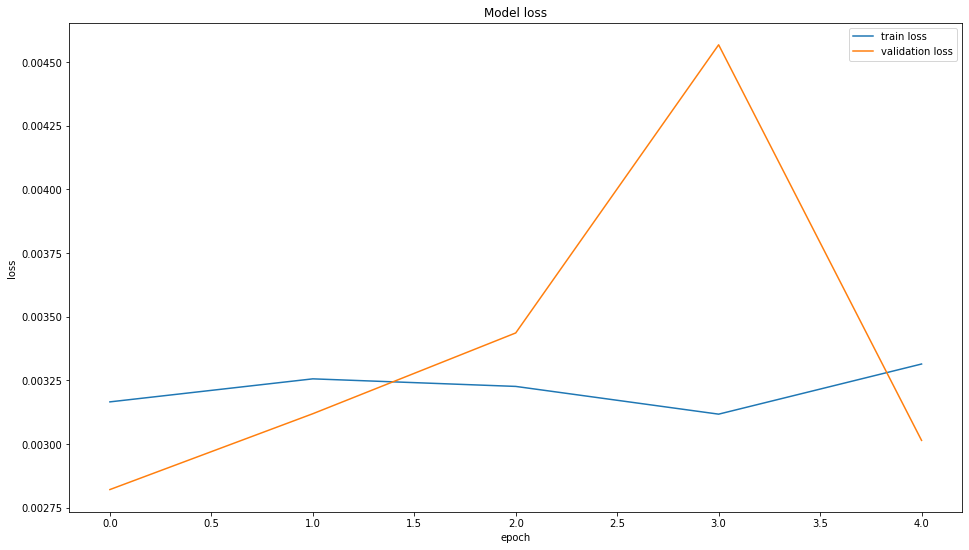

In [42]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [43]:
data_val = X_scaler.fit_transform(data[["Zasedenost", "Points_of_interest"]].tail(48))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

array([[39.978825, 37.97042 , 36.46119 , 32.06148 , 29.021946, 24.690647,
        21.12789 , 19.058767, 17.317657, 16.345505]], dtype=float32)

In [44]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [45]:
timeseries_evaluation_metrics_func(list(map(lambda el: el[0], data[["Zasedenost"]].tail(10).values)),pred_Inverse[0])

Evaluation metric results:-
MSE is : 258.724891212106
MAE is : 12.634331893920898
RMSE is : 16.084927454362546
MAPE is : 95.16239017131282
R2 is : -65.51025481031003



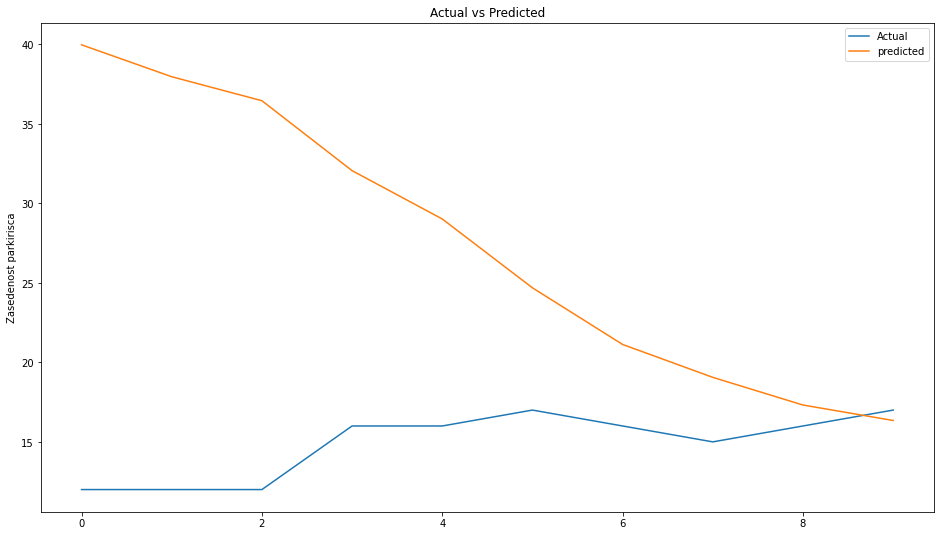

In [46]:
plt.figure(figsize=(16, 9))
plt.plot(list(map(lambda el: el[0], data[["Zasedenost"]].tail(10).values)))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Zasedenost parkirisca")
plt.legend(('Actual', 'predicted'))
plt.show()